# Microcircuits II: Hierarchical Prediction
#### What are we doing here?
In this part of the Microcircuits project, I intend to build a more complex model to represent the predictive brain. Fundamentally, it has the same structure as part I -- stimulus, a central prediction or prior, the calculation of prediction errors based on the difference between the two.

This time, however, I am approaching it from a neural accuracy standpoint. Each function has been split up between different neuron types -- specifically pyramidal, VIP, SST and PV neurons.

These groups are interconnected in a number of ways, with the output of each neuron group feeding into other groups, with the Pyr neurons being the core belief updators, combining metrics like precision, prediction error, stimulus and prior prediction.
We will be using two layers of PYR neurons to simulate a short term learning/ belief updation and a slower, higher/top-down layer.

To make this easier, and for readability, I'm using object-oriented programming, using classes heavily.

---

Please scroll down to the **Bibliography** to see the papers I'm basing my decisions on.

---

**PS:** We will also be using *we* and *I* interchangeably - not out of any real plan, but because I keep forgetting :/

#### A note on Part I
You can find the first part of this project [here](https://colab.research.google.com/drive/1uRAF0bxxPxIq3WqEXUpblVvxOX5XkFaC?usp=sharing). In it, I outlined a simulation using just numpy to model the predictive brain.
Microcircuits I was all about creating a minimum viable product: It had input, prediction error calculation, belief/priors, and belief updation using prediction error and precision estimates.

## The framework:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### Create input trials.
Just like last time, we'll generate random arrays with slightly changing means and variances.

In [ ]:
def generate_trials(n_trials, samples_per_trial = 30, start_mean = 5, start_std = 2.0, mean_shift_std = 0.05, std_shift_std = 0.01):

  # Containers
  all_trials = []
  means = [start_mean] #to start with
  stds = [start_std]

  # Generate trials
  for i in range(n_trials):
      # Draw samples for each trial
      trial_data = np.random.normal(start_mean, start_std, samples_per_trial)

      # Ensure the variance isn't too close to 0 (prevents division by zero when calculating precision)
      if np.var(trial_data) < 1e-6:
          trial_data += np.random.normal(0, 1e-3, size=samples_per_trial)

      all_trials.append(trial_data) #adds the stimulus for each trial

      # Updates mean and std with slight shifts (you can change the shift intensity in the function args)
      start_mean += np.random.normal(0, mean_shift_std)
      start_std += np.random.normal(0, std_shift_std)
      start_std = max(0.1, start_std)  # Ensuring std doesn't go too low (safeguard against collapse, also prevents division by zero.)

      means.append(start_mean) # so we know all the means and stds used
      stds.append(start_std)

  return all_trials, means, stds

### The brain regions.
The 4 brain regions we'll be focusing on are the SST, PV, PY and perhaps VIP.

- SST (Somatostatin) neurons encode subtractive prediction error (input - pred)
- PV (Parvalbumin) neurons encode variance/ precision
- PY (Pyramidal) neurons represent beliefs/priors and send those downstream.
- VIP (Vasoactive) neurons modulate inhibition (?)

#### Sensory input
While I won't go too far in depth here, we'll do as we did in Part I and extract the mean and variance from the sensory input received

In [ ]:
def sensory_stat(input_data):
        return np.mean(input_data), np.var(input_data)

#### **Pyramidal neurons (PYR)**

The pyramidal (PYR) neurons:
- Stores belief (our priors, current_beliefs in part I)
- Receives prediction error from SST and PV
- Updates beliefs accordingly

Thus, the *update_mean*, *update_var* functions and main *update* function, all come under this class. We'll let sensory_input and pred_error be the inputs from outside the class.

In [ ]:
class PYR_Layer:
    def __init__(self, init_mean=0.0, init_var=1.0, min_var=0.1, alpha_var=0.01):
      self.mean = init_mean
      self.var = init_var
      self.min_var = min_var
      self.alpha_var = alpha_var

    def update_var(self, pred_error):
      self.var += self.alpha_var * (pred_error[0]**2 - self.var)
      self.var = max(self.var, self.min_var)

    def update_mean(self, sensory_input, PV_precision):
      var_belief = max(self.var, self.min_var)
      var_sensory = max(sensory_input[1], self.min_var)
      pi_belief = 1.0 / var_belief
      pi_sensory = PV_precision # This is where the PV neurons will calculate precision.
      self.mean = (pi_belief * self.mean + pi_sensory * sensory_input[0]) / (pi_belief + pi_sensory)

    def update(self, sensory_input, PV_precision, pred_error):
      self.update_var(pred_error)
      self.update_mean(sensory_input, PV_precision)
      return self.mean, np.sqrt(self.var)  # returning std dev for tracking

The pyr neurons play enough of a role that I've split them into two layers; You'll see that pyr1 and pyr2 are called, and I've connected them to the other layers in different ways during the final setup. The second layer is meant for more slow learning.
Note: In the brain, they're layer 3/5 and something else -- not exactly 1 and 2.

#### Parvalbumen InterNeurons (PV)
They receive input strength or error signal, turn it into precision metrics, and pass it on to PYR. They *modulate the gain for PYR*.
Friston 2005, Bastos 2012

In [ ]:
class PV_Neurons():
  def __init__(self, gain = 1.0):
    self.gain = gain

  def compute_precision(self, sensory_input):
    mean, var = sensory_input
    self.precision = self.gain / (var)
    return max(0.1, self.precision)

#### Somatostatin interneurons (SST)
The somatostatin neurons are one of the most well-known predictive neuron groups.
They play a role in comparing sensory input with feedback predictions -- i.e. calculating prediction error.

In [ ]:
class SST_neurons():
  def __init__(self):
    self.inhib_factor = 1.0

  def pred_error(self, sensory_input, pyr_prediction):
    return sensory_input - pyr_prediction

  def inhib_pred_error(self, sensory_input, pyr_prediction, feedback_prediction=None):
    if feedback_prediction is not None:
      pred = np.array(pyr_prediction) + np.array(feedback_prediction)
    else:
      pred = np.array(pyr_prediction)
    return self.inhib_factor * (sensory_input - pred)

  def VIP_inhib(self, vip_input):
    self.inhib_factor = 1.0 - vip_input #we'll ensure vip_input is between 0 and 1, set it to 0 initially.

The above is basically the entirety of Part I in a single function, split into pyramidal neurons, sst interneurons, etc.([Friston K., 2005](https://doi.org/10.1098/rstb.2005.1622))

#### VIP neurons
The VIP neurons inhibit SST neurons (which in turn are PYR inhibitors). So we've introduced a variable in SST above, the inhibition factor, which we can increase or decrease using VIP. I'm not entirely sure about my understanding here-- so i'm leaving a context_sensitivity option, allowing me to turn off VIP neuron activity when running the simulation.

In [ ]:
class VIP_Neurons():
  def __init__(self, context_sensitivity=True):
    self.context_sensitivity = context_sensitivity

  def inhib_sst(self, pred_error, threshold = 0.5):
    if self.context_sensitivity:
      if np.abs(pred_error[0]) < threshold:
        return 1.0
      else:
        return 0.0 #don't inhibit
    return 0.0 #if not context sensitive, vip inhibition is off.


### Results:

#### Running the simulation

In [ ]:
#generating trials / input
all_trials, means, stds = generate_trials(300)

In [ ]:
# Running the Sim
pyr1 = PYR_Layer()
pv = PV_Neurons()
sst = SST_neurons()
vip = VIP_Neurons(context_sensitivity=True)
pyr2 = PYR_Layer(init_mean=0.0, init_var=1.0) #This will be the higher layer PYR.

#Setting up the array of means, stds, so we can track their change across trials.
beliefs_mean = []
beliefs_std = []
high_belief_mean = []

for trial in all_trials:
  #Sensory
  sensory_input = np.array(sensory_stat(trial)) #Sensory input's mean and variance are determined

  #PYR 2: Feedback from higher layer | just mean.
  feedback_prediction = [pyr2.mean, 0.0]

  #PV
  sensory_precision = pv.compute_precision(sensory_input) #Sensory input's precision is determined at the PV

  #VIP - SST interplay
  basic_pred_error = sst.pred_error(sensory_input, [pyr1.mean, pyr1.var]) #SST calculates error between prediction/prior and new input
  vip_inhib = vip.inhib_sst(basic_pred_error,threshold = 0.5)#vip determines if this pred error is enough for sst to modulate pyr
  sst.VIP_inhib(vip_inhib) #with this inhibition factor, we compute prediction error, update it in SST

  pred_error = sst.inhib_pred_error(sensory_input, [pyr1.mean, pyr1.var], feedback_prediction)

  # Now we update at PYR1:
  new_mean1, new_std1 = pyr1.update(sensory_input, sensory_precision, pred_error)
  beliefs_mean.append(new_mean1)
  beliefs_std.append(new_std1)

  # Update at PYR2: Higher level, slower update:
  low_level_input = np.array([pyr1.mean, pyr1.var])
  pyr2.mean += 0.01 * (low_level_input[0] - pyr2.mean) #very slow learning rate
  high_belief_mean.append(pyr2.mean)

#### Errors and plots

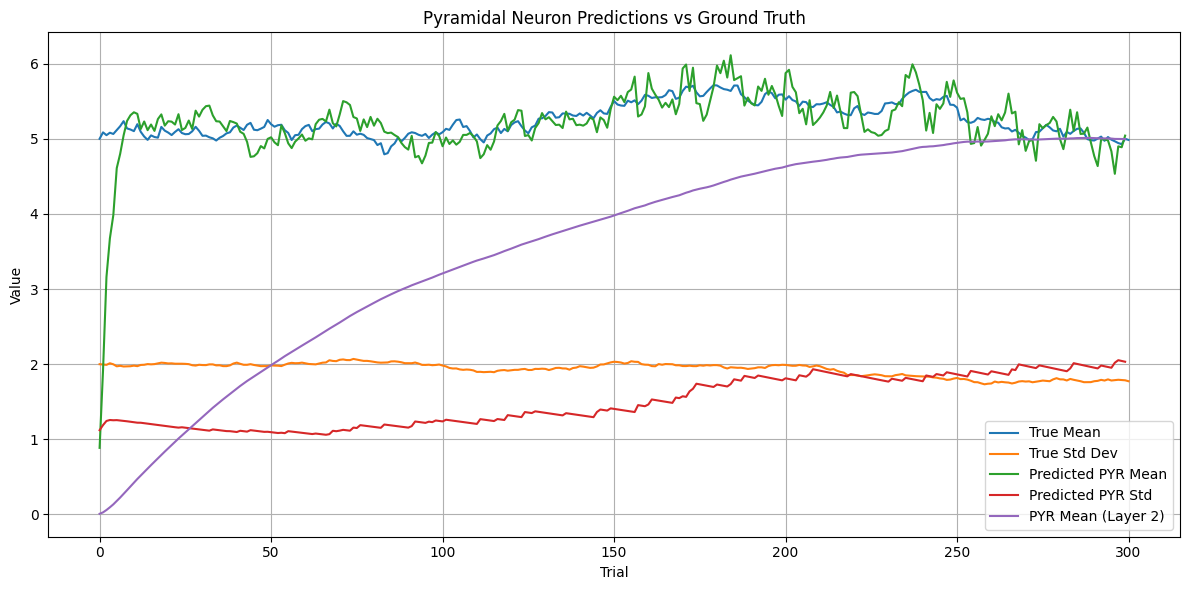

In [ ]:
# === PLOT RESULTS ===
plt.figure(figsize=(12, 6))
plt.plot(means, label='True Mean')
plt.plot(stds, label='True Std Dev')
plt.plot(beliefs_mean, label='Predicted PYR Mean')
plt.plot(beliefs_std, label='Predicted PYR Std')
plt.plot(high_belief_mean, label='PYR Mean (Layer 2)')
plt.title('Pyramidal Neuron Predictions vs Ground Truth')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

You can clearly see that the predicted mean converges rapidly, but it still tends to over/undershoot afterwards - since we're not using step sizes/ learning rates, other tweaks to the formula might be useful.

The predicted std rapidly approaches the true std. dev, but seems to overshoot and keep going.

The layer 2 pyr mean demonstrates its convergence with the true mean, taking much longer, but unaffected by brief fluctuations.

I won't further optimize this model to fit the data, if it means changing the model away  from what's neuroscientifically accurate. However, there's already been an improvement when I implemented the feedback system -- ideally adding more systems and making this more accurate to reality will also improve the simulations ability to predict.

The following is a bit of boilerplate code, that runs 4 different error tests to see if the model fared better with or without VIP inhibition

In [ ]:
from sklearn.metrics import mean_squared_error

#generating trials / input
all_trials, means, stds = generate_trials(300)
means = means[1:]  # skip the initial value
stds = stds[1:]

# === METRICS ===
def calc_rmse(true_vals, predicted_vals):
    return np.sqrt(mean_squared_error(true_vals, predicted_vals))

def calc_cumulative_abs_error(true_vals, predicted_vals):
    return np.sum(np.abs(np.array(true_vals) - np.array(predicted_vals)))

def neg_log_likelihood(trial_data, mean, std):
    return np.sum(0.5 * np.log(2 * np.pi * std**2) + 0.5 * ((trial_data - mean) ** 2) / (std**2))

def calc_avg_lag(true_vals, predicted_vals):
    lag = np.abs(np.array(true_vals[1:]) - np.array(predicted_vals[:-1]))
    return np.mean(lag)

# === FUNCTION TO RUN A MODEL WITH OR WITHOUT VIP ===
def run_and_evaluate(vip_enabled):
    pyr = PYR_Layer()
    pv = PV_Neurons()
    sst = SST_neurons()
    vip = VIP_Neurons(context_sensitivity=vip_enabled)

    beliefs_mean = []
    beliefs_std = []
    total_nll = 0

    for trial in all_trials:
        sensory_input = np.array(sensory_stat(trial))
        sensory_precision = pv.compute_precision(sensory_input)

        basic_pred_error = sst.pred_error(sensory_input, [pyr.mean, pyr.var])
        vip_inhib = vip.inhib_sst(basic_pred_error)
        sst.VIP_inhib(vip_inhib)
        pred_error = sst.inhib_pred_error(sensory_input, [pyr.mean, pyr.var])

        new_mean, new_std = pyr.update(sensory_input, sensory_precision, pred_error)
        beliefs_mean.append(new_mean)
        beliefs_std.append(new_std)

        total_nll += neg_log_likelihood(trial, new_mean, new_std)

    rmse = calc_rmse(means, beliefs_mean)
    cae = calc_cumulative_abs_error(means, beliefs_mean)
    lag = calc_avg_lag(means, beliefs_mean)

    return {
        "rmse": rmse,
        "cumulative_abs_error": cae,
        "avg_lag": lag,
        "neg_log_likelihood": total_nll
    }

# === RUN BOTH VERSIONS ===
results_off = run_and_evaluate(vip_enabled=False)
results_on = run_and_evaluate(vip_enabled=True)

# === PRINT COMPARISON ===
def compare_metrics(results_on, results_off):
    print("Evaluation of VIP Gating in Predictive Coding\n")
    print(f"{'Metric':<25}{'VIP OFF':<15}{'VIP ON':<15}{'Interpretation'}")
    print("-" * 70)
    for metric, label in zip(["rmse", "cumulative_abs_error", "avg_lag", "neg_log_likelihood"],
                             ["RMSE (↓ better)", "Cumulative Abs Error (↓)", "Average Lag (↓)", "Neg Log-Likelihood (↓)"]):
        off = results_off[metric]
        on = results_on[metric]
        direction = "✅" if on < off else "⚠️"
        print(f"{label:<25}{off:<15.3f}{on:<15.3f}{direction}")

compare_metrics(results_on, results_off)


Evaluation of VIP Gating in Predictive Coding

Metric                   VIP OFF        VIP ON         Interpretation
----------------------------------------------------------------------
RMSE (↓ better)          0.372          0.372          ✅
Cumulative Abs Error (↓) 47.748         47.577         ✅
Average Lag (↓)          0.165          0.163          ✅
Neg Log-Likelihood (↓)   42922.842      48409.726      ⚠️


If you run it unchanged, you'll see that there really isn't any appreciable difference.

## Bibliography
A brief summary of the papers I read when building this, and how they influenced my understanding/ how I used them in this model.

1. **Wilmes, (2023)** ([Link](https://www.biorxiv.org/content/10.1101/2023.05.11.540393v7)):

 Reason for this framework, selection of these specific neuron groups (PYR neurons,and inhibitory neuron types PV, VIP, SST), use of SST to measure prediction error, use of precision (uncertainty).

 Also see **[Wilmes et al (2025)](https://elifesciences.org/articles/95127)**
 - For more discussion breaking down exactly what role SST, PV, etc play.
 - A model that slightly disagrees with what I built -- for instance, the paper suggests that PV estimates variance, while I have also put the calculation of precision under PV (since it doesn't matter in this case).z


2. **Friston (2018) ([Link](https://doi.org/10.1038/s41593-018-0200-7))**:

  Titled "Does predictive coding have a future?", it's a paper that gives an overview of the predictive coding theory, how it caught on, and describes in (not-too-)broad strokes how precision, bayesian theory, etc were used to build predictive models of the brain.

3. **Rao and Ballard (1999)** ([Link](https://www.nature.com/articles/nn0199_79)):

  Important 1999 paper, basis of the hierarchical idea. Both this paper and friston 2005 are the basis of the more bayesian model used for precision.

4. **Bastos et al. (2012) ([Link](https://www.cell.com/neuron/fulltext/S0896-6273(12)00959-2?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627312009592%3Fshowall%3Dtrue))**:

  A paper that connected microcircuitry in hierarchical cortical regions with predictive coding. Goes considerably in depth -- I have yet to go through it in its entirety.

5. **Keller & Mrsic-Flogel (2018) ([Link](https://www.sciencedirect.com/science/article/pii/S0896627318308572))**

  Part I in a nutshell:
  > "a comparator circuit that computes the prediction error between bottom-up input and predictions, a circuit to maintain an internal representation that gives rise to predictions, and a modulating or gating signal that sets the precision or weight of the prediction error"
  
6. **Garrett et al (2020) ([Link](https://elifesciences.org/articles/50340))**:
  
  Not directly relevant. However, playing around with this dataset was my first introduction to predictive processing in the VIP and SST neurons. Perhaps you will find it equally instructive.

8.  **Friston (2005) ([Link](https://pubmed.ncbi.nlm.nih.gov/15937014/))**:

  Builds towards a general theory, minimisation of free energy.

## Endnote
I hope this proved instructive and helpful. There's still a great deal to do, now that I have a rudimentary model.
- Modifying it to work with larger dimensional data (torch tensors?) and working on more raw neural data
- A deeper literature dive to identify other regions to include, and refine my model to approximate.
- Convert this to a spiking model, using Brian2 perhaps.
- Studying uncertainty and confidence -- will the values of likelihood be estimated centrally? distributed? (There's a lot of debate regarding this).

- In short, tweaking this to generate testable observations.
Regardless, thank you for dropping by.

~NB